In [1]:
import arbor as A
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Helper functions

**NOTE** You _can_ look at these, if you want, but they contain mainly unimportant details.

Use matplotlib to draw morphologies in 3d

In [51]:
def plot_morphology(mrf, *, fg=None):
    tree = mrf.to_segment_tree()
    colors = sns.color_palette('Set1')
    if not fg:
        fg = plt.figure(figsize=(10, 10))
    ax = fg.add_subplot(projection='3d')
    for seg in tree.segments:
        x0 = seg.prox.x
        x1 = seg.dist.x
        y0 = seg.prox.y
        y1 = seg.dist.y
        z0 = seg.prox.z
        z1 = seg.dist.z
        r0 = seg.prox.radius
        r1 = seg.dist.radius
        tag = seg.tag
    
        ax.plot(xs=[x0, x1], 
                ys=[y0, y1], 
                zs=[z0, z1], 
                color=colors[tag], 
                lw=(r0 + r1)) # average diameter from radius
    ax.set_xlabel(r'x $(\mu m)$')
    ax.set_ylabel(r'y $(\mu m)$')
    ax.set_zlabel(r'z $(\mu m)$')
    return fg, ax

Run a single cell model defined by morphology and decor and plot the membrane potential

In [87]:
def run_single_cell(mrf, dec):
    cell = A.cable_cell(mrf, dec)
    sim = A.single_cell_model(cell)
    sim.probe('voltage', where='(location 0 0.5)', frequency=10)
    sim.run(100)
    trace = sim.traces[0]

    fg, ax = plt.subplots()
    ax.plot(trace.time, trace.value)
    ax.set_ylim(-80, 20)
    ax.set_xlim(0, 100)
    ax.set_ylabel('$U/mV$')
    ax.set_xlabel('$t/ms$')

# Loading Morphologies

Morphologies describe the layout of a cell in 3d space. Arbor uses them to determine the electrical connections inside a cell in simulations. 
Most of the actual geometric information is _discarded_ during the setup, hence the name 'morphology'.

We can, however extract the geometry to visualize the input data using a simple helper and matplotlib.

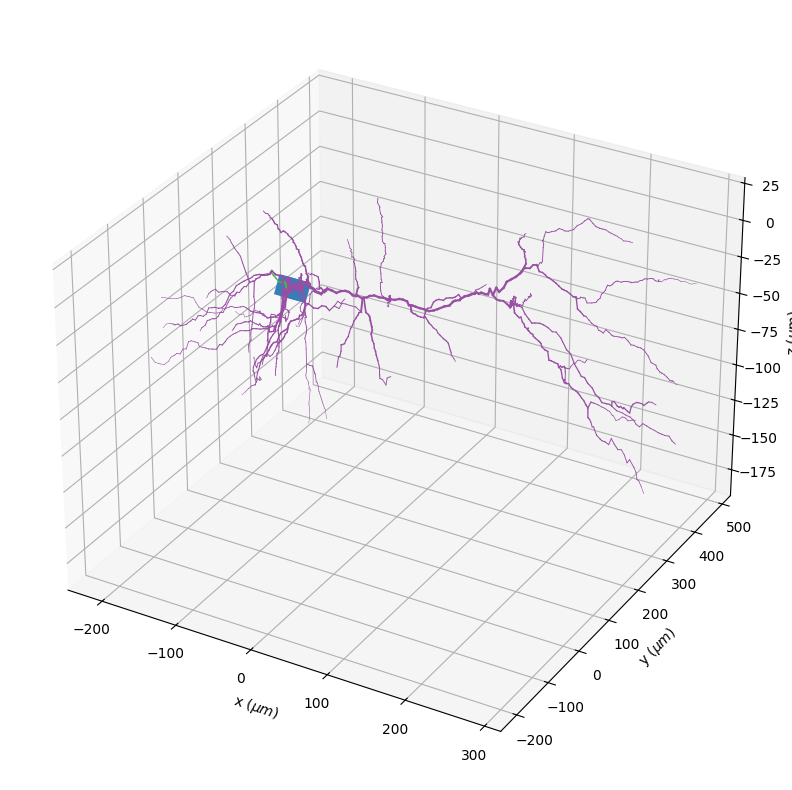

In [90]:
# SWC is a simple and common interchange format. We can load it in Arbor like this.
mrf = A.load_swc_neuron('Acker2008.swc')

fg = plt.figure(figsize=(10, 10))
fg, ax = plot_morphology(mrf, fg=fg)

Different colors denote regions of the cell that have been recorded during the segmentation process:

- soma
- basal dendrite
- apical dendrite
- axon

# From Morphologies to cells

A cell, as far as we are concerned at least, comprises two main things

- a morphology
- an assignment of parameters and dynamics

So far, this is likely very familiar. However, using Arbor, we can assign different dynamics to different subsets of the cell's surface.
For efficiency reasons, neither the morphology nor the assignments are performed on the actual simulated object. Rather, we construct
descriptions towards building a simulation which then is converted to an efficient simulation. This might feel a bit weird at first, 
but is extremely important for performance.

The assignment of parameters and dynamics is handled via the `decor`

In [82]:
dec = A.decor()

As we are handling a surface, two different kinds of operations are needed: one for point-like objects and one for sub-sections of the surface.
To assign objects with a finite extent, we use

In [83]:
dec.paint('(all)', Vm = -50) # set initial membrane potential in mV

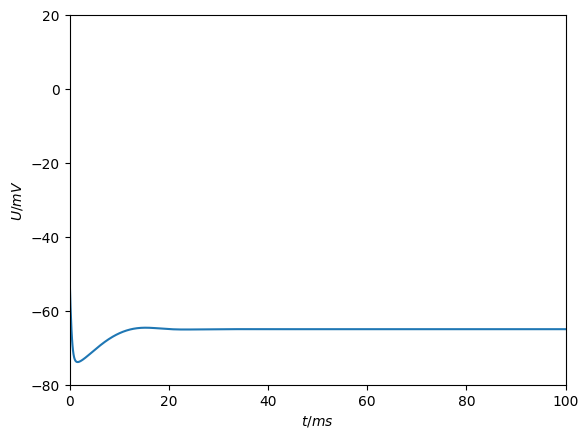

In [91]:
run_single_cell(mrf, dec)

Congratulations, at this point you have run your first simulation in Arbor. 

# Adding Dynamics

Certainly the last plot felt a bit underwhelming. Let's change that by adding an ion channel. We start with the simplest possible
model, a passive current.

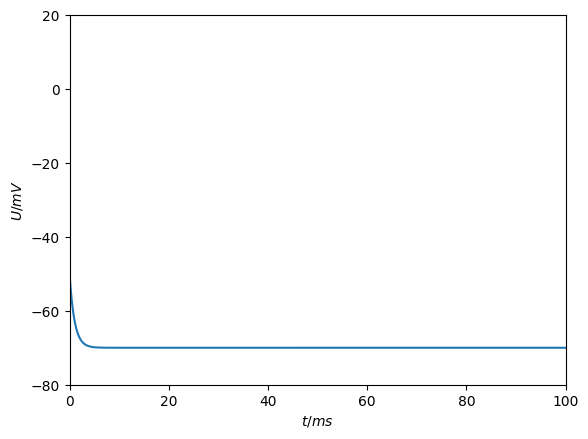

In [94]:
# we use a fresh decor here, as they are immutable objects.
dec = A.decor() 
dec.paint('(all)', Vm = -50)
# density indicates that we want an ion channel with a finite area
dec.paint('(all)', A.density('pas'))

run_single_cell(mrf, dec)

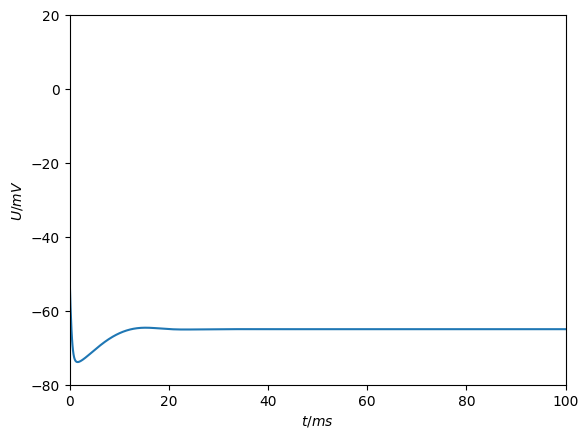

In [95]:
dec = A.decor() 
dec.paint('(all)', Vm = -50)
dec.paint('(all)', A.density('hh'))

trace = run_single_cell(mrf, dec)

# Adding a Stimulus

Still, nothing much is happening in our model. 